In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore') # filter some warning messages
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import cartopy.feature as cfeature
import seaborn as sns
import glob
import os
import fnmatch
import calendar

In [2]:
# Generals
ldp = '/Users/sol/Documents/LargeData/' # data folder

# regional domain
lnep = np.array([[43, 48.5],[-129, -123]]) # 230, 237
lqin = np.array([[46.25, 47.75],[-125.5, -123.5]]) # 230, 237 # domain for zoom in map
# QIN region
qbox = np.array([[-124.05,-124.33,-125.07,-124.774,-124.05],[46.53,47.4,47.4,46.53,46.53]]) 
# calendar.month_name[mon]
pers=['Dec-Feb','Jun-Aug']

In [3]:
fn = '../data/ETOPO1_QIN.nc'
ds_topo = xr.open_dataset(fn)
ds_topo.close()
topo = ds_topo.z.sel(y=slice(lnep[0,0],lnep[0,1]),x=slice(lnep[1,0],lnep[1,1]))
X,Y=np.meshgrid(topo.x,topo.y)

In [4]:
qin = xr.open_dataset(ldp+'/QIN/qin_mask.nc')
qin.close()
qin.coords['lon'] = np.mod(qin.coords['lon'] + 180,360) - 180
qin = qin.polygon_mask.sel(lat=slice(lnep[0,0],lnep[0,1]),lon=slice(lnep[1,0],lnep[1,1]))
qin = qin.where(qin!=0,np.nan)

# number of pixels in the mask
npx = qin.count(dim=['lat','lon']).values

In [5]:
fishdt = pd.read_csv('../data/QiN_dataspecifics.csv')
# https://docs.google.com/spreadsheets/d/1zYiVVgZR4DLksM_yABO_zPnsXe7Q6Uh_8tvxt3n60N0/edit?usp=sharing')
# Transform O2
fishdt['Om'] = fishdt['Om']/44.661
var = ['thetao','o2']   
depth = ['surface','bottom']
ssps = ['ssp245']
fishes=fishdt['Species']

In [6]:
def get_suitable_habitat_values(x, m, s, z):
    func = lambda x, m, s, z: z * np.exp(-0.5*((x - m)/s)**2)
    return xr.apply_ufunc(func, x, m, s, z)

def T_weighted_suitable_habitat(fishnum, ds_tmp):
    import math
    
    # generate mask for final tally
    mask1 = ds_tmp.where((ds_tmp>=fishdt['Tm'][fishnum])&(ds_tmp<=fishdt['Tx'][fishnum]), np.nan)*0 + 1
    mask2 = ds_tmp.where((ds_tmp<=fishdt['Tm'][fishnum])|(ds_tmp>=fishdt['Tx'][fishnum]), np.nan)*0
    mask = xr.concat((mask1,mask2),'z').mean(dim='z')
    #mask = ds_tmp.where((ds_tmp>=Trange[fishnum,0])&(ds_tmp<=Trange[fishnum,1]), np.nan)
    
    # define normal distribution for the t range and set values
    m = (fishdt['Tx'][fishnum]+fishdt['Tm'][fishnum])/2
    s = (fishdt['Tx'][fishnum]-fishdt['Tm'][fishnum])*0.68/2
    # scale to 0-1
    xw = np.arange(fishdt['Tm'][fishnum], fishdt['Tx'][fishnum], 0.01)
    z = 1/s/np.sqrt(2*math.pi)
    yw = z * np.exp(-0.5*((xw - m)/s)**2)
    ymin = yw.min()
    ymax = (yw-ymin).max()
    #ymax = yw.max()
    #plt.plot(xw, (yw-ymin)/ymax)
    #plt.show()
    
    ds_new = get_suitable_habitat_values(ds_tmp, m, s, z)
    ds_new = (ds_new - ymin)*100 / ymax
    #ds_new = (ds_new)*100 / ymax
    ds_new = ds_new * mask
    
    return ds_new
    

In [7]:
def suitable_habitat_seas_allmod_comb(fishnum):            
    
    for clim in ssps:
        for i2 in depth:
            # for each variable at given depth
            for i in var:
                # optimal range thresholds
                if i=='thetao':
                    th1 = fishdt['Tm'][fishnum]
                    th2 = fishdt['Tx'][fishnum]
                else:
                    th1 = fishdt['Om'][fishnum]
                    th2 = 100
                # for each model
                fns = glob.glob(ldp+'/QIN/downscaled_data/'+clim+'/'+i+'/'+i2+'/*.nc')
                # build datasets from all models
                for modn,fn in enumerate(fns):
                    # model name
                    tmps = fn.split('/')
                    tmps2 = tmps[-1].split('_')
                    modname = tmps2[0]+'_'+tmps2[1]
                    #print(modn,models[nummod])
                    ds_Ts = xr.open_dataset(fn)
                    ds_Ts.close()
                    ds_Ts.coords['lon'] = np.mod(ds_Ts.coords['lon'] + 180,360) - 180
                    # select only region of interest (large)
                    ds_Ts = ds_Ts[i].sel(lat=slice(lnep[0,0],lnep[0,1]),lon=slice(lnep[1,0],lnep[1,1]),time=slice('1994-01-01','2019-12-31')).groupby('time.season').mean()
            
                    if i=='thetao':
                        # calculate suitable habitat for T
                        tmp = T_weighted_suitable_habitat(fishnum, ds_Ts)
                    else:
                        #tmp = ds_Ts.where((ds_Ts>=th1)&(ds_Ts<=th2), np.nan)
                        tmp = ds_Ts.where(ds_Ts<th1, 1)
                        tmp = tmp.where(tmp==1, 0)
                        #tmp = tmp*qin
                    
                    # data array
                    if modn==0:
                        fechas = ds_Ts.season
                    tmp_ds = xr.DataArray(data=tmp,dims=['season','lat','lon'],
                                        coords=dict(season=fechas,lat=ds_Ts.lat,lon=ds_Ts.lon))
                    
                    if i=='thetao':
                        if modn==0: 
                            allmodT = xr.Dataset({modname:tmp_ds})
                        else:
                            allmodT[modname] = tmp_ds
                    else:
                        if modn==0: 
                            allmodO = xr.Dataset({modname:tmp_ds})
                        else:
                            allmodO[modname] = tmp_ds
                    
            # compare that both vars in each models
            # for each model that has Oxygen
            di = 0
            for i in list(allmodO):
                tmpO = allmodO[i].values
                try:
                    tmpT = allmodT[i].values
                    OTcomb = tmpO * tmpT
                    tmp_OT = xr.DataArray(data=OTcomb, dims=['season','lat','lon'],
                                        coords=dict(season=fechas,lat=ds_Ts.lat,lon=ds_Ts.lon))
                    
                    if di==0:
                        allmod_otcomb = xr.Dataset({i:tmp_OT})
                        di += 1
                    else:
                        allmod_otcomb[i] = tmp_OT
                except:
                    x=1
                    
            varns = clim+'_'+i2
            allmod_otcomb.to_netcdf(ldp+'QIN/downscaled_data/suitable_habitat_v2/present_season_OT_'+fishes[fishnum]+'_'+varns+'_allmods.nc')
            

In [8]:
for fishn in range(len(fishes)):
    suitable_habitat_seas_allmod_comb(fishn)

In [22]:
def make_map(ds, dom, tit, dp, depth=False, d1=0, d2=0, cbs=True):
    comap='RdYlGn'
    cd = 'b'
        
    pers=['Dec-Feb','Jun-Aug']
    
    for i in range(2):
        if cbs==True:
            fig=plt.figure(figsize=(4,4),dpi=150) # QIN domain
        else:
            fig=plt.figure(figsize=(3,3),dpi=150)
        ax = fig.add_subplot(1, 2, i+1, projection=ccrs.PlateCarree())
        ax.coastlines(resolution='10m',linewidth=1.5,color='black',alpha=0.8,zorder=4)
        ax.add_feature(cfeature.LAND, color='lightgrey')
        ax.set_extent([dom[1,0],dom[1,1],dom[0,0],dom[0,1]],crs=ccrs.PlateCarree())
        if dom[1,1]-dom[1,0]>3:
            xt = range(int(np.ceil(dom[1,0])), int(np.floor(dom[1,1]))+1,3)
        else:
            xt = range(int(np.ceil(dom[1,0])), int(np.floor(dom[1,1]))+1,1)
        if dom[0,1]-dom[0,0]>3:
            yt = range(int(np.ceil(dom[0,0])), int(np.floor(dom[0,1]))+1,2)
        else:
            yt = range(int(np.ceil(dom[0,0])), int(np.floor(dom[0,1]))+1,1)
            
        ax.set_xticks(xt, crs=ccrs.PlateCarree())
        ax.set_yticks(yt, crs=ccrs.PlateCarree())
        plt.xticks(fontsize=8)
        plt.yticks(fontsize=8)
        ax.xaxis.set_major_formatter(LongitudeFormatter(zero_direction_label=True))
        ax.yaxis.set_major_formatter(LatitudeFormatter())
        plt.grid(True, zorder=0,alpha=0.5)
        ax.set_aspect(1.5)
        plt.contour(X,Y,topo,[-3000,-2000,-1000,-500,-200,-150, -100,-50],colors='k',linewidths=0.5, linestyles='solid', zorder=3, alpha=0.5)
        if depth==True:
            plt.contour(X,Y,topo,[ -d2, -d1],colors=cd,linewidths=1, linestyles='solid', zorder=3, alpha=0.8)
        plt.plot(qbox[0,:],qbox[1,:],c='k',lw=2,zorder=5, alpha=0.7)

        vmi = 0
        vmx = 100

        if i==0:
            plt.contourf(ds.lon, ds.lat, ds[0,:,:], cmap=comap, alpha=0.9, vmin=vmi, vmax=vmx)
        else:
            plt.contourf(ds.lon, ds.lat, ds[1,:,:], cmap=comap, alpha=0.9, vmin=vmi, vmax=vmx)

        if cbs==True:
            cb = plt.colorbar(fraction=0.015, orientation='horizontal', ticks=[*range(vmi,vmx+1,20)])
                
            cb.ax.tick_params(labelsize='x-small')
            cb.set_label(label=tit, size='x-small')#, weight='bold')
        
        plt.text(dom[1,0]+0.1,dom[0,1]-0.1, pers[i],fontsize=8,backgroundcolor='w')
        plt.tight_layout(h_pad=1)
        plt.show()
        if cbs==True:
            plt.savefig('../figures/suitable_habitat/present/'+fishes[fishh]+'_'+dp+'_QINdomain.png')
        else:
            plt.savefig('../figures/suitable_habitat/present/'+fishes[fishh]+'_'+dp+'_Largedomain.png')
        

Dungeness Crab
surface


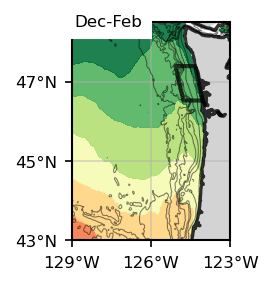

no data



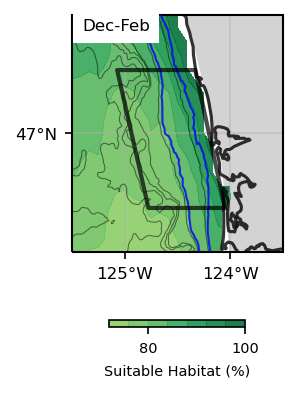

no data

Dungeness Crab
bottom


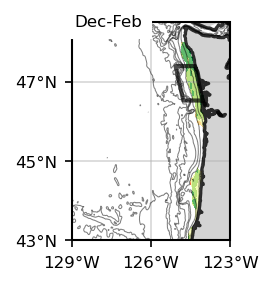

no data



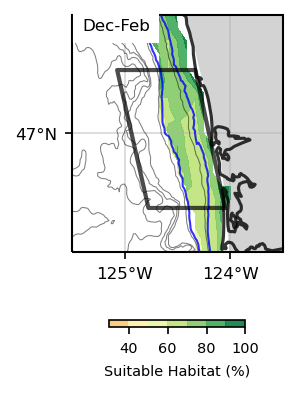

no data

Sablefish
surface


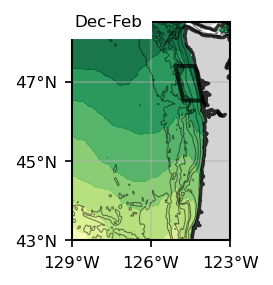

no data



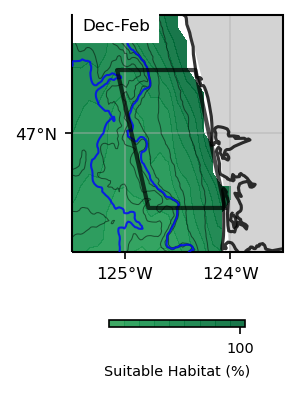

no data

Sablefish
bottom


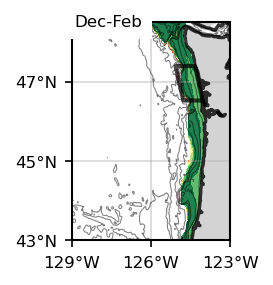

no data



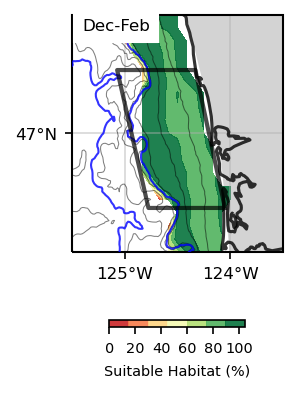

no data

P. Halibut
surface


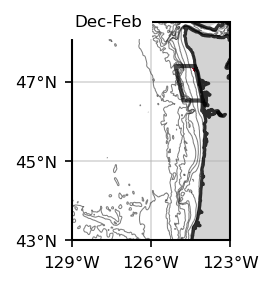

no data

no data

P. Halibut
bottom


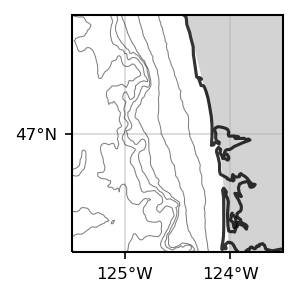

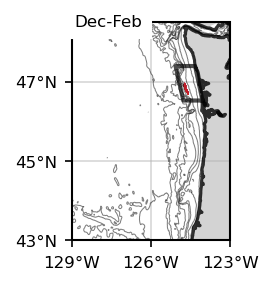

no data

no data

Chinook
surface


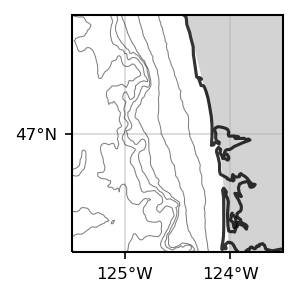

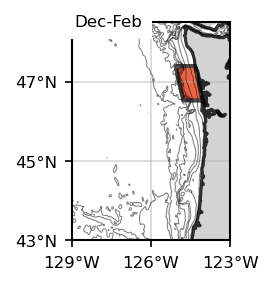

no data



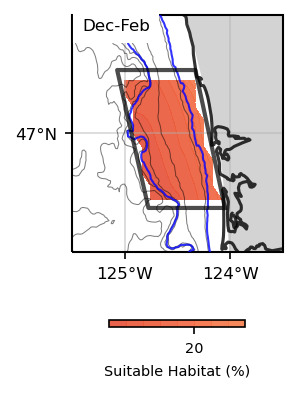

no data

Chinook
bottom


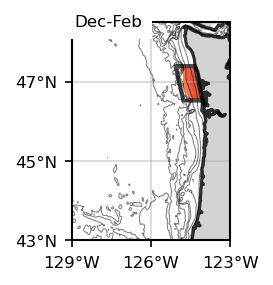

no data



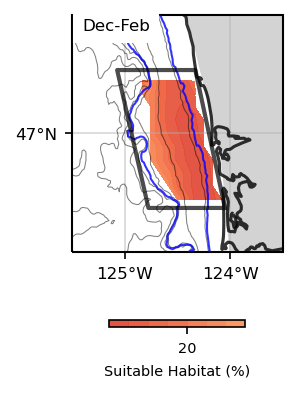

no data

Coho
surface


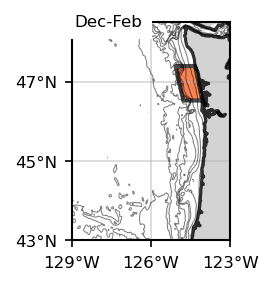

no data



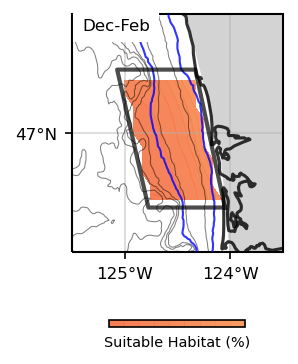

no data

Coho
bottom


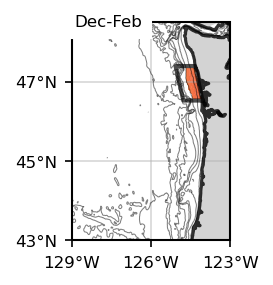

no data



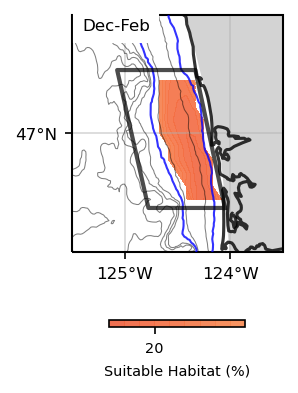

no data

Razor Clams
surface


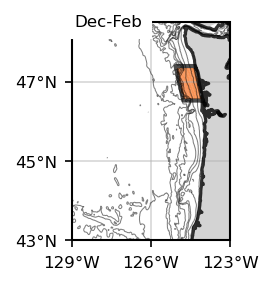

no data



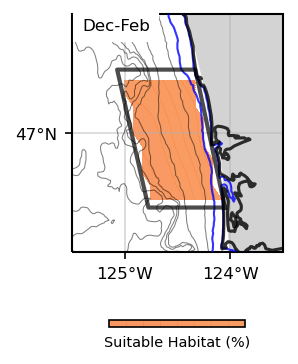

no data

Razor Clams
bottom


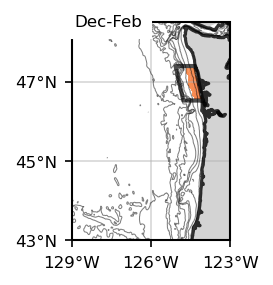

no data



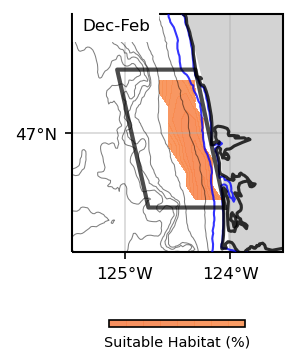

no data

Albacore
surface
no data

no data

Albacore
bottom
no data

no data



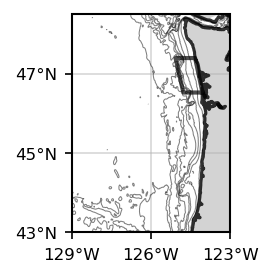

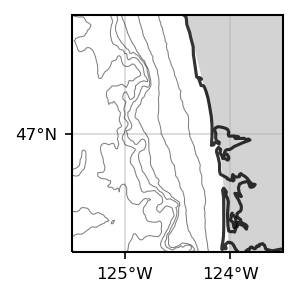

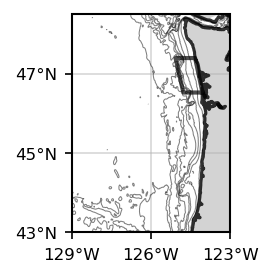

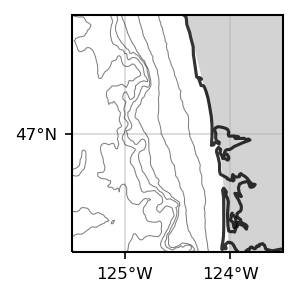

In [23]:
tit='Suitable Habitat (%)'
for fishn in range(len(fishes)):
    for dp in depth:
        print(fishes[fishn])
        print(dp)
        fn = ldp+'QIN/downscaled_data/suitable_habitat_v2/present_season_OT_'+fishes[fishn]+'_ssp245_'+dp+'_allmods.nc'
        ds_present = xr.open_dataset(fn)
        ds_present.close()
        ds_present = ds_present.where(ds_present.season!='MAM',drop=True)
        ds_present = ds_present.where(ds_present.season!='SON',drop=True)
        
        # average across models (variables in the data frame)
        meanx = ds_present.to_array(dim='new').mean('new', skipna=True)
        ds_present['allmod']=meanx.where(meanx>=1)
        
        try:
            make_map(ds_present.allmod, ldom,  tit, dp, cbs=False)
        
        except:
            print('no data\n')
            
        ds_present = ds_present.sel(lat=slice(lqin[0,0],lqin[0,1]),lon=slice(lqin[1,0],lqin[1,1]))
        
        try:
            make_map(ds_present.allmod, lqin, tit, dp, depth=True, d1=fishdt.at[fishn,'Dm'], d2=fishdt.at[fishn,'Dx'])
        except:
            print('no data\n')
            

In [ ]:
ds_present
meanx = ds_present.to_array(dim='new').mean('new')
ds_present['allmod']=meanx
ds_present

In [ ]:
# DJF, JJA both seasons averages 
for jx, j in enumerate(fishes):
    for i in range(4):
        print('\n ** ',j,' **')
        if i==0:
            print('Temperature, bottom')
            fn = ldp+'QIN/downscaled_data/ssp245/thetao/bottom/CanESM5-CanOE_r2i1p2f1_ssp245_sd+ba_final_thetao_bottom_1_final_subset.nc'
            tit = 'Temperature ($^{\circ}$C)'
            var = 'thetao'
        elif i==1:
            print('Temperature, surface')
            fn = ldp+'QIN/downscaled_data/ssp245/thetao/surface/CanESM5-CanOE_r2i1p2f1_ssp245_sd+ba_final_thetao_surface_depth_5_1_final_subset.nc'
            tit = 'Temperature ($^{\circ}$C)'
            var = 'thetao'
        elif i==2:
            print('DO, bottom')
            fn = ldp+'QIN/downscaled_data/ssp245/o2/bottom/CanESM5-CanOE_r2i1p2f1_ssp245_sd+ba_final_o2_bottom_1_final_subset.nc'
            tit = 'DO (mL/L)'
            var = 'o2'
        else:
            print('DO, surface')
            fn = ldp+'QIN/downscaled_data/ssp245/o2/surface/CanESM5-CanOE_r2i1p2f1_ssp245_sd+ba_final_o2_surface_depth_5_1_final_subset.nc'
            tit = 'DO (mL/L)'
            var = 'o2'

        ds = xr.open_dataset(fn)
        ds.close()
        ds.coords['lon'] = np.mod(ds.coords['lon'] + 180,360) - 180
        ds_present = ds[var].sel(lat=slice(ldom[0,0],ldom[0,1]),lon=slice(ldom[1,0],ldom[1,1]),time=slice('1993-01-01','2020-12-31')).groupby('time.season').mean()
        ds_present = ds_present.where(ds_present.season!='MAM',drop=True)
        ds_present = ds_present.where(ds_present.season!='SON',drop=True)

        # # suitable habitat
        if var == 'thetao':
            #th1, th2 = Trange[jx,0], Trange[jx,1]
            rg = (Trange[jx,1] - Trange[jx,0])*0.2
            th1 = Trange[jx,0] - rg # 80% of range
            th2 = Trange[jx,0] + rg
        else:
            rg = 1.5 # hypoxia limt
            th2 = 100 # no upper limit for oxygen
            # th2 = O2range[jx,0], 100 # no upper limit for oxygen

        ds_present = ds_present.where((ds_present>=th1)&(ds_present<=th2), np.nan)

        d1,d2 = Deprange[jx,0], Deprange[jx,1]
        
        try:
            make_map(ds_present, ldom, var, tit, True, d1, d2)

            ds_present = ds_present.sel(lat=slice(lqin[0,0],lqin[0,1]),lon=slice(lqin[1,0],lqin[1,1]))

            make_map(ds_present, ldom_qin, var, tit, True, d1, d2)
        except:
            plt.show()
            print('\nNo suitable habitat\n')


In [ ]:
fishes[0]